In [1]:
from typing import Callable, Tuple
import numpy as np


class GPRegressor:
    """
    Class for performing Gaussian Process regression.

    Args:
        mean_args (dict): Arguments for the mean function.
        correlation_args (dict): Arguments for the correlation function.
        mean_function (Callable): The mean function.
        correlation_func (Callable): Kernel function used to compute correlations.
        noise (float): Noise term, optional.
        return_stds (Bool): Should we return stds on predictions.
    """

    def __init__(self, mean_args: dict, correlation_args: dict, mean_function: Callable, correlation_func: Callable,
                 noise: float = 0):
        self.mean_args = mean_args
        self.corr_args = correlation_args
        self.mean_function = mean_function
        self.corr_func = correlation_func
        self.noise = noise
        self.mean_x_training = None
        self.cov_training_training = None
        self.cov_training_predict = None
        self.cov_predict_predict = None
        self.inv_cov_training_training = None
        self.x_training = None
        self.y_training = None

    def calc_corr_matr(self, a: np.ndarray, b: np.ndarray = None) -> np.ndarray:
        b = a if b is None else b
        K = self.corr_func(a, b, **self.corr_args)

        if b is a:
            K = K + np.eye(len(a)) * self.noise
        return K

    def fit(self, x: np.ndarray, y: np.ndarray):
        self.x_training = x
        self.y_training = y
        self.mean_x_training = self.mean_function(x, **self.mean_args)
        self.cov_training_training = self.calc_corr_matr(x, x)
        self.inv_cov_training_training = np.linalg.inv(self.cov_training_training)

    def predict(self, x: np.ndarray, return_stds = False) -> Tuple[np.ndarray, np.ndarray] | np.ndarray:
        cov_training_predict = self.calc_corr_matr(x, self.x_training)
        cov_predict_predict = self.calc_corr_matr(x, x)
        mean_x_predict = self.mean_function(x)
        predictions = mean_x_predict + np.dot(np.dot(cov_training_predict, self.inv_cov_training_training),
                                              (self.y_training - self.mean_x_training))

        if return_stds:
            prediction_stds = np.diag(
                cov_predict_predict - np.dot(self.inv_cov_training_training,
                                             np.transpose(cov_training_predict)))
            return predictions, prediction_stds
        else:
            return predictions


def priormean(xin, c2 = 0.25):
    return c2 * xin ** 2

def corr_func(a: np.ndarray, b: np.ndarray, sigmaf2=1.0, ell=1.0):
    diff = a[:, None] - b[None, :]
    return sigmaf2 * np.exp(-diff ** 2 / (2 * ell ** 2))


In [2]:
gpReg = GPRegressor({'c2': 0.25}, {'ell': 1, 'sigmaf2': 2}, priormean, corr_func, 0.005)

In [3]:
x_train=np.array([1,2,3,4])
y_train=np.array([0.25,0.95,2.3,3.9])
x_pred = np.arange(0,7,0.2)
gpReg.fit(x_train, y_train)
gpReg.predict(x_pred)

array([ 0.0606967 ,  0.0714365 ,  0.09575771,  0.13289663,  0.18343298,
        0.24955051,  0.33490756,  0.44404333,  0.5813865 ,  0.75008535,
        0.95098624,  1.18209882,  1.43877877,  1.71465619,  2.00310223,
        2.29884213,  2.59925943,  2.90502151,  3.21986325,  3.54962077,
        3.90082175,  4.27924217,  4.68880636,  5.1310629 ,  5.6052751 ,
        6.10899107,  6.63885707,  7.19142638,  7.76377739,  8.35385297,
        8.9605286 ,  9.58348111, 10.2229544 , 10.87950895, 11.55381324])

Optima: x=0.900, y=0.810


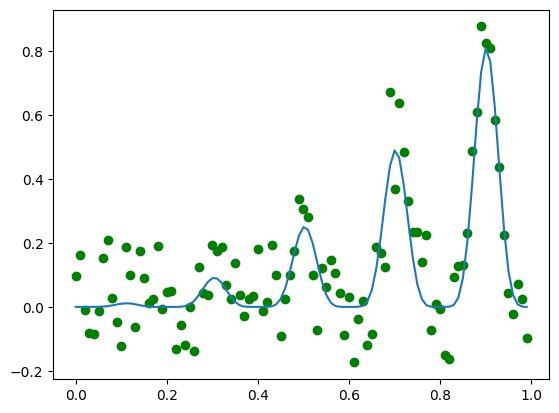

In [5]:
# example of the test problem
from math import sin
from math import pi
from numpy import arange
from numpy import argmax
from numpy.random import normal
from matplotlib import pyplot

# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

# grid-based sample of the domain [0,1]
X = arange(0, 1, 0.01)
# sample the domain without noise
y = [objective(x, 0) for x in X]
# sample the domain with noise
ynoise = [objective(x) for x in X]
# find best result
ix = argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))
# plot the points with noise
pyplot.scatter(X, ynoise, color='green')
# plot the points without noise
pyplot.plot(X, y)
# show the plot
pyplot.show()